# (1) Install Libraries

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
import tensorflow_text as text

# (2) Load BindingDB dataset

참고로 본 데이터는 https://www.bindingdb.org/bind/chemsearch/marvin/SDFdownload.jsp?download_file=/bind/downloads/BindingDB_BindingDB_Inhibition_2021m2.tsv.zip 데이터를 특정한 기준을 따라 가공한 데이터임.

가공 기준은 https://www.nature.com/articles/s41598-020-79682-4 논문을 참고하였음. 기준은 구체적으로 다음과 같음.
- **Target Source Organism According to Curator or DataSource** 필드에서는 "Homo sapiens", "Rattus norvegicus", Mus musculus", "Bos taurus"에 해당하는 값만 고려할 것
- $\text{IC50} \leq \text{100 nm}$ or $\text{Kd} \leq \text{100 nm}$ or $\text{EC50} \leq \text{100 nm}$
- 화학식별자 컬럼을 포함할 것 (PuhChem CID)


In [194]:
raw_data = pd.read_csv('/home/messy92/Leo/Drug-discovery-research/data/BindingDB_BindingDB_Inhibition (prep).csv')


In [195]:
raw_data

,BindingDB Reactant_set_id,Ligand SMILES,BindingDB Ligand Name,Target Name Assigned by Curator or DataSource,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),PubChem CID,ZINC ID of Ligand,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,PDB ID(s) of Target Chain,UniProt (SwissProt) Recommended Name of Target Chain
0,455059,ONC(=O)CCCCn1cc(C(=O)Nc2ccccc2)c(=O)c2ccccc12,Quinolone-based HDAC inhibitor 4a,Histone acetylases (HDACs),Homo sapiens,NaN,32.0,NaN,NaN,131953857.0,ZINC33410638,5,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,"3MAX,4BKX,5ICN,6Z2J,6Z2K",Histone deacetylase 1
1,455061,COc1ccc(NC(=O)c2cn(CCCCC(=O)NO)c3ccccc3c2=O)cc1,Quinolone-based HDAC inhibitor 4c,Histone acetylases (HDACs),Homo sapiens,NaN,39.0,NaN,NaN,131953859.0,ZINC04863960,5,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,"3MAX,4BKX,5ICN,6Z2J,6Z2K",Histone deacetylase 1
2,455065,ONC(=O)CCCCn1cc(C(=O)Nc2ccncc2)c(=O)c2ccccc12,Quinolone-based HDAC inhibitor 4g,Histone acetylases (HDACs),Homo sapiens,NaN,90.0,NaN,NaN,131953863.0,ZINC00164363,5,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,"3MAX,4BKX,5ICN,6Z2J,6Z2K",Histone deacetylase 1
3,455066,ONC(=O)CCCCn1cc(C(=O)Nc2nccs2)c(=O)c2ccccc12,Quinolone-based HDAC inhibitor 4h,Histone acetylases (HDACs),Homo sapiens,NaN,42.0,NaN,NaN,131953864.0,ZINC02686872,5,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,"3MAX,4BKX,5ICN,6Z2J,6Z2K",Histone deacetylase 1
4,455067,Cc1csc(NC(=O)c2cn(CCCCC(=O)NO)c3ccccc3c2=O)n1,Quinolone-based HDAC inhibitor 4i,Histone acetylases (HDACs),Homo sapiens,NaN,0.0,NaN,NaN,131953865.0,ZINC03257684,5,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,"3MAX,4BKX,5ICN,6Z2J,6Z2K",Histone deacetylase 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16881,868736,CCCC(C(CC(C)C)C(=O)NC(CCCCNC(=O)OCc1ccccc1)C(=...,"med.21724, Compound 10",Angiotensin-converting enzyme 2,Homo sapiens,NaN,1.0,NaN,NaN,NaN,NaN,1,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,"1R42,1R4L,2AJF,3KBH,6LZG,6VW1",Angiotensin-converting enzyme 2
16882,868739,CC(C)CC(NC(Cc1cncn1Cc1cc(Cl)cc(Cl)c1)C(O)=O)C(...,"med.21724, Compound 13",Angiotensin-converting enzyme 2,Homo sapiens,NaN,0.0,NaN,NaN,NaN,NaN,1,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,"1R42,1R4L,2AJF,3KBH,6LZG,6VW1",Angiotensin-converting enzyme 2
16883,868747,CC(C)C(NC(=O)OCc1ccccc1)C(=O)NC(Cc1ccccc1)C=O,MDL28170::Z-Val-Phe-CHO::benzyl N-[(1S)-2-meth...,Cathepsin (L and K),Homo sapiens,NaN,3.0,NaN,NaN,9907994.0,ZINC08584799,1,MNPTLILAAFCLGIASATLTFDHSLEAQWTKWKAMHNRLYGMNEEG...,"1ICF,1MHW,2VHS,2XU3,2XU4,2XU5,2YJ2,2YJ8,2YJ9,2...",Procathepsin L
16884,868749,CCc1ccccc1NC(=O)CSC(=O)NNC(=O)C(Cc1c[nH]c2cccc...,"med.21724, Compound 21",Cathepsin (L and K),Homo sapiens,NaN,7.0,NaN,NaN,NaN,NaN,1,MNPTLILAAFCLGIASATLTFDHSLEAQWTKWKAMHNRLYGMNEEG...,"1ICF,1MHW,2VHS,2XU3,2XU4,2XU5,2YJ2,2YJ8,2YJ9,2...",Procathepsin L


# (3) 전처리하기
## (3-1) 일부 변수들만 뽑아주기
BindingDB에 포함된 모든 변수를 사용해 줄 필요는 없다. 오히려 일부 변수들은 동일한 정보를 다르게 표현하고 있을 뿐인 경우도 많다.

Target-Drug Translation 문제를 풀기 위해 필수적인 변수는 다음과 같다.

* 표적 단백질 시퀀스 (Target Chaing Sequence)
* 리간드 시퀀스 (Ligand SMILES)
* 단백질 - 리간드 반응 변수 (ex., Ki, IC50, Kd, EC50 etc.)

그 외 변수들은 선택사항으로 자유롭게 추가한다.

본 연구에선 기존 15개 변수들 중 아래와 같이 6개 변수들만을 선택하였다.

```python
raw_data = raw_data.loc[:, ['Ligand SMILES', 'BindingDB Target Chain Sequence', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']]
```

이때 각 변수들의 의미는 다음과 같다.

- **Ligand SMILES** : Target Protein에 반응한다고 알려진 리간드 화합물을 SMILES로 표현한 값 (시퀀스)
- **Binding DB Target Chain Sequence** : Target Protein의 아미노산 염기서열 (amino acids sequence) (시퀀스)
- **Ki (nM)**
- **IC50 (nM)**
- **Kd (nM)**
- **EC50 (nM)**



In [196]:
sample_data = raw_data.loc[:, ['Ligand SMILES', 'BindingDB Target Chain Sequence', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']]
sample_data


,Ligand SMILES,BindingDB Target Chain Sequence,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM)
0,ONC(=O)CCCCn1cc(C(=O)Nc2ccccc2)c(=O)c2ccccc12,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,NaN,32.0,NaN,NaN
1,COc1ccc(NC(=O)c2cn(CCCCC(=O)NO)c3ccccc3c2=O)cc1,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,NaN,39.0,NaN,NaN
2,ONC(=O)CCCCn1cc(C(=O)Nc2ccncc2)c(=O)c2ccccc12,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,NaN,90.0,NaN,NaN
3,ONC(=O)CCCCn1cc(C(=O)Nc2nccs2)c(=O)c2ccccc12,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,NaN,42.0,NaN,NaN
4,Cc1csc(NC(=O)c2cn(CCCCC(=O)NO)c3ccccc3c2=O)n1,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYG...,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...
16881,CCCC(C(CC(C)C)C(=O)NC(CCCCNC(=O)OCc1ccccc1)C(=...,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,NaN,1.0,NaN,NaN
16882,CC(C)CC(NC(Cc1cncn1Cc1cc(Cl)cc(Cl)c1)C(O)=O)C(...,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,NaN,0.0,NaN,NaN
16883,CC(C)C(NC(=O)OCc1ccccc1)C(=O)NC(Cc1ccccc1)C=O,MNPTLILAAFCLGIASATLTFDHSLEAQWTKWKAMHNRLYGMNEEG...,NaN,3.0,NaN,NaN
16884,CCc1ccccc1NC(=O)CSC(=O)NNC(=O)C(Cc1c[nH]c2cccc...,MNPTLILAAFCLGIASATLTFDHSLEAQWTKWKAMHNRLYGMNEEG...,NaN,7.0,NaN,NaN


## (3-2) 객체 타입 확인하기

In [197]:
# 객체 타입 알아보기
print(sample_data.dtypes)

Ligand SMILES                       object
BindingDB Target Chain Sequence     object
Ki (nM)                            float64
IC50 (nM)                          float64
Kd (nM)                            float64
EC50 (nM)                          float64
dtype: object


## (3-3)  Protein amino acids와 Ligand SMILES 시퀀스의 길이분포 확인

### 3-3-1. apply-lambda를 활용하여 시퀀스 길이 추출 및 trunc_sample_data 생성

In [198]:
# 단백질과 화합물의 시퀀스 길이 분포 추출
protein_len_distribution = raw_data.apply(lambda x : len(x['BindingDB Target Chain Sequence']), axis = 1)
compound_len_distribution = raw_data.apply(lambda x : len(x['Ligand SMILES']), axis = 1)

# 단백질의 경우 소수의 너무 긴 단백질이 존재하므로 길이 하위 80% 까지만 고려.
protein_q80 = protein_len_distribution.quantile(0.8)
truncated_protein_len_distribution = protein_len_distribution[protein_len_distribution.lt(protein_q80)]

# protein sequence는 길이 하위 80%에 해당하는 샘플만 고려하는 trunc_sample_data 만들어주기
trunc_sample_data = sample_data[protein_len_distribution.lt(protein_q80)]

### 3-3-2. 추출한 길이 데이터를 (plot을 그리기 쉽게) long-format 데이터프레임으로 변환해주기

In [199]:
# protein 길이 데이터 만들기 (시퀀스 대상과 시퀀스 길이를 의미하는 변수로 구성된 2차원 데이터 프레임 만들기)
protein_len_data = pd.concat([pd.Series(np.repeat("protein", len(truncated_protein_len_distribution))), truncated_protein_len_distribution], axis = 1)
# compound 길이 데이터 만들기 (시퀀스 대상과 시퀀스 길이를 의미하는 변수로 구성된 2차원 데이터 프레임 만들기)
compound_len_data = pd.concat([pd.Series(np.repeat("compound", len(compound_len_distribution))), compound_len_distribution], axis = 1)

# 위에서 만든 두 개의 데이터 프레임을 행방향으로 합치기
sequence_len_dist_data = pd.concat([protein_len_data, compound_len_data], axis = 0)
sequence_len_dist_data.columns = ['sequence', 'length']

### 3-3-3. 시퀀스 길이 분포 플롯팅

/home/messy92/.conda/envs/unist_server/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


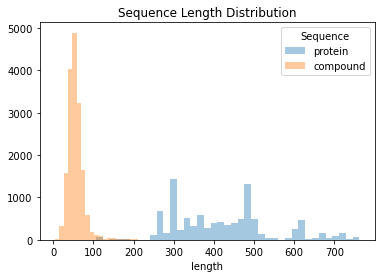

In [200]:
sns.distplot(sequence_len_dist_data[sequence_len_dist_data.sequence == "protein"]['length'], label = "protein", kde = False)
sns.distplot(sequence_len_dist_data[sequence_len_dist_data.sequence == "compound"]['length'], label = "compound", kde = False)
plt.legend(title = 'Sequence')
plt.title('Sequence Length Distribution')
plt.show()

## (3-2) 시퀀스 데이터 토큰화 및 정수 임베딩하기

#### (1) 최대 길이 저장 

In [201]:
# Protein, Ligand 시퀀스 토큰화 하기
protein_max_len = max(trunc_sample_data['BindingDB Target Chain Sequence'].apply(lambda x : len(x)))
compound_max_len = max(trunc_sample_data['Ligand SMILES'].apply(lambda x : len(x)))



#### (2) 시퀀스 토큰화

In [204]:
# 표적 단백질 시퀀스  (Amino acids sequence represented as FASTA)
FASTA_dat = np.array(copy.deepcopy(trunc_sample_data['BindingDB Target Chain Sequence']))
for idx, FASTA in enumerate(trunc_sample_data['BindingDB Target Chain Sequence']):
    FASTA_dat[idx] = list(FASTA)

FASTA_dat = list(FASTA_dat)

# 약물 시퀀스 (compound sequence represented as SMILES)
SMILES_dat = np.array(copy.deepcopy(trunc_sample_data['Ligand SMILES']))
for idx, SMILES in enumerate(trunc_sample_data['Ligand SMILES']):
    SMILES_dat[idx] = list(SMILES)

SMILES_dat = list(SMILES_dat)

#### (3) 시퀀스 정수 임베딩

정수 임베딩을 위해 텐서플로-케라스 전처리 라이브러리 `preprocessing.text`와 `preprocessing.sequence`에서 `Tokenizer` 및 `pad_sesquences` 설치하기

In [206]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



`Tokenizer`를 활용해서 토크나이저 객체 `my_tokenizer` 정의. 이 때 `filters = ' '`와 `lower = False` 명심. 

`filters`는 토큰화하지 않을 문자를 설정하는 인자로 default값으로 모든 알파벳 외 문자들을 토큰화에서 배제하도록 되어있음. SMILES같은 경우 `[`, `@` 등 특수 문자들이 의미를 가지는 토큰으로 간주되어야 하므로 `filters`를 SMILES에 등장하지 않을 법한 어떤 문자로 설정해주어야 함. 

`lower`는 모든 알파벳을 소문자로 강제하는 인자로 default값으로 `True`가 설정되어 있음. SMILES에서는 대문자 C와 소문자 c가 다른 의미를 가지므로 `lower = False`로 해주어야 함.

In [208]:
# 단백질 시퀀스 정수 임베딩
protein_tokenizer = Tokenizer(filters = ' ', lower = False)
protein_tokenizer.fit_on_texts(FASTA_dat)
encoded_FASTA = protein_tokenizer.texts_to_sequences(FASTA_dat)
padded_FASTA = pad_sequences(encoded_FASTA, maxlen = protein_max_len, padding = 'post')

# 약물 시퀀스 정수 임베딩
compound_tokenizer = Tokenizer(filters = ' ', lower = False)
compound_tokenizer.fit_on_texts(SMILES_dat)
encoded_SMILES = compound_tokenizer.texts_to_sequences(SMILES_dat)
padded_SMILES = pad_sequences(encoded_SMILES, maxlen = compound_max_len, padding = 'post')

#### (4) 토큰화 및 정수 임베딩 결과 확인

In [213]:
# 단백질 시퀀스 토큰화 및 정수 임베딩 결과 확인
print(protein_tokenizer.word_index)
print(padded_FASTA)

# 약물 시퀀스 토큰화 및 정수 임베딩 결과 확인
print(compound_tokenizer.word_index)
print(padded_SMILES)

{'L': 1, 'G': 2, 'S': 3, 'A': 4, 'V': 5, 'E': 6, 'K': 7, 'P': 8, 'R': 9, 'T': 10, 'D': 11, 'I': 12, 'F': 13, 'N': 14, 'Q': 15, 'Y': 16, 'H': 17, 'M': 18, 'C': 19, 'W': 20, 'l': 21, 'a': 22, 'e': 23, 'k': 24, 'i': 25, 's': 26, 'q': 27, 'd': 28, 'r': 29, 'n': 30, 't': 31, 'f': 32, 'v': 33, 'm': 34, 'h': 35, 'p': 36, 'c': 37, 'g': 38, 'y': 39, 'w': 40, '1': 41, 'X': 42, '2': 43, '3': 44, '4': 45, '5': 46, '6': 47, '7': 48, '8': 49, '9': 50, '0': 51}
[[18  4 15 ...  0  0  0]
 [18  4 15 ...  0  0  0]
 [18  4 15 ...  0  0  0]
 ...
 [18 14  8 ...  0  0  0]
 [18 14  8 ...  0  0  0]
 [18 14  8 ...  0  0  0]]
{'c': 1, 'C': 2, '(': 3, ')': 4, '1': 5, 'O': 6, 'N': 7, '=': 8, '2': 9, 'n': 10, '@': 11, '[': 12, ']': 13, 'H': 14, '3': 15, '-': 16, 'F': 17, 'S': 18, 'l': 19, '4': 20, 's': 21, '\\': 22, 'o': 23, '#': 24, 'B': 25, 'r': 26, '5': 27, '+': 28, '/': 29, 'I': 30, 'P': 31, '6': 32, '7': 33, '8': 34, 'e': 35, 'R': 36, '.': 37, '9': 38, 'b': 39, 'i': 40, 'u': 41}
[[6 7 2 ... 0 0 0]
 [2 6 1 ... 

{'c': 1, 'C': 2, '(': 3, ')': 4, '1': 5, 'O': 6, 'N': 7, '=': 8, '2': 9, 'n': 10, '@': 11, '[': 12, ']': 13, 'H': 14, '3': 15, '-': 16, 'F': 17, 'S': 18, 'l': 19, '4': 20, 's': 21, '\\': 22, 'o': 23, '#': 24, 'B': 25, 'r': 26, '5': 27, '+': 28, '/': 29, 'I': 30, 'P': 31, '6': 32, '7': 33, '8': 34, 'e': 35, 'R': 36, '.': 37, '9': 38, 'b': 39, 'i': 40, 'u': 41}
[[6 7 2 ... 0 0 0]
 [2 6 1 ... 0 0 0]
 [6 7 2 ... 0 0 0]
 ...
 [2 2 3 ... 0 0 0]
 [2 2 1 ... 0 0 0]
 [2 2 3 ... 0 0 0]]
